_**Mihir Bendre**_: _COE 352 Project 2_

# Finite Element Method Solver

This Python script implements a **Finite Element Method (FEM) solver** for solving partial differential equations (PDEs). The script supports Forward Euler (FE) and Backward Euler (BE) methods for time integration and includes functionality for assembling FEM matrices, applying boundary conditions, solving the system, and visualizing results.

## Function definitions


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Basis functions & derivatives
def bf(e_len):
    b1 = lambda z: (1 - z) / 2
    b2 = lambda z: (1 + z) / 2
    db = np.array([-1 / 2, 1 / 2])
    q = [-1 / np.sqrt(3), 1 / np.sqrt(3)]
    bfq = np.array([[b1(z), b2(z)] for z in q])
    return bfq, db, 2 / e_len, e_len / 2

# Source term
def f(x, t):
    return (np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x)

# Analytical solution
def u(x, t):
    return np.exp(-t) * np.sin(np.pi * x)

# Initial condition
def u0(x):
    return np.sin(np.pi * x)


# Dirichlet BC
def dbc(m, n):
    m[0, :] = m[-1, :] = m[:, 0] = m[:, -1] = 0
    m[0, 0] = m[-1, -1] = 1
    bc = np.eye(n)
    bc[0, 0] = bc[-1, -1] = 0
    return m, bc

# Build FEM matrices
def fem(n, ts, k, m, f_mat, map, bfq, db, dsc, isc, e_len):
    q = [-1 / np.sqrt(3), 1 / np.sqrt(3)]
    for e in range(n - 1):
        lm = np.zeros((2, 2))
        lk = np.zeros((2, 2))
        for i in range(2):
            for j in range(2):
                lm[i, j] = sum(bfq[i, l] * bfq[j, l] for l in range(2)) * e_len
                lk[i, j] = db[i] * dsc * db[j] * dsc * isc * 2
        gn = map[e].astype(int)
        for i in range(2):
            for j in range(2):
                k[gn[i], gn[j]] += lk[i, j]
                m[gn[i], gn[j]] += lm[i, j]
        f_mat[e, :] = -sum(f(z, ts) * bfq[0, l] for l, z in enumerate(q)) * (1 / 8)
    return m, k, f_mat


# Euler solve
def esolve(n, ts, dt, ms, im, m, f, bc, method, xi, ie):
    u_mat = np.zeros((n, ts + 1))
    u_mat[:, 0] = u0(xi)
    for t in range(ts):
        if method == 'FE':
            u_mat[:, t + 1] = u_mat[:, t] - dt * ms.dot(u_mat[:, t]) + dt * im.dot(f[:, t])
        else:
            u_mat[:, t + 1] = (1 / dt) * ie.dot(m.dot(u_mat[:, t])) + ie.dot(f[:, t])
        u_mat[:, t + 1] = bc.dot(u_mat[:, t + 1])
    return u_mat

# Euler matrices
def em(m, k, dt):
    im = np.linalg.inv(m)
    emat = (1 / dt) * m + k
    return im, np.dot(im, k), np.linalg.inv(emat)


# Plot
def plot(xc, uc, xd, ud, ts, method):
    plt.plot(xc, uc, label='True', color="green")
    label = "FE" if method == "FE" else "BE"
    plt.plot(xd, ud[:, ts], label=f'{label} (n={ts})', color="magenta")
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('True vs FEM')
    plt.legend()
    plt.show()

# FEM solver
def fem_solve(N, n, xi, ts, h, dt, method):
    while True:
        if method in ['FE', 'BE']:
            m, k, f = np.zeros((N, N)), np.zeros((N, N)), np.zeros((N, n + 1))
            map = np.vstack((np.arange(0, N - 1), np.arange(1, N))).T
            bfq, db, dsc, isc = bf(h)
            m, k, f = fem(N, ts, k, m, f, map, bfq, db, dsc, isc, h)
            m, bc = dbc(m, N)
            im, ms, ie = em(m, k, dt)
            u_mat = esolve(N, n, dt, ms, im, m, f, bc, method, xi, ie)
            xc = np.linspace(0, 1, N)
            xh = np.linspace(0, 1, 1000)
            uc = u(xh, 1)
            plot(xh, uc, xc, u_mat, n, method)
            break
        else:
            print("Error: Pick 'FE' or 'BE'")


## Forward Euler: stable plot

To start off, let's plot with forward euler method, nodes **N = 11**, and stable timestep of 1/n, where **n = 551**.

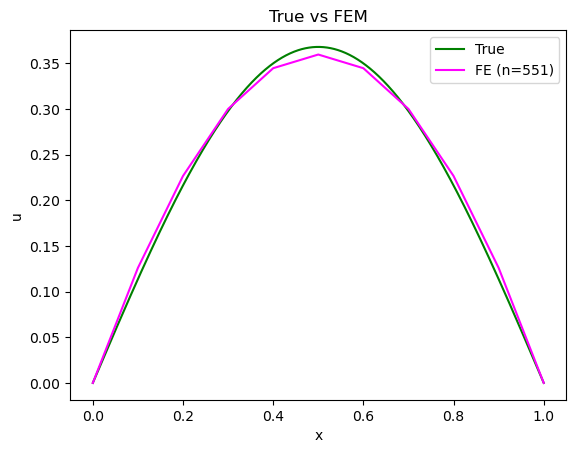

In [46]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 11
        # Timestep:
        n = 551
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'FE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Forward Euler: unstable timestep
Keeping N as is, **N = 11**, I tested various timesteps and found that for the timestep of 1/n, where **n <= 277**, the forward euler method becomes unstable. 

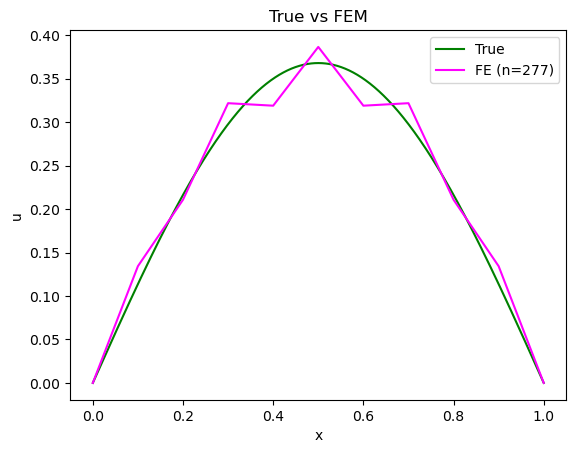

In [26]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 11
        # Timestep:
        n = 277
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'FE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Forward Euler: increasing N
Now, to check if the solution changes when the number of nodes increases, I set **N = 21**, and tried playing around with different values of n, finding in this case (by trial-and-error), that the forward euler method becomes unstable for a timestep of 1/n, where **n <= 1175**.

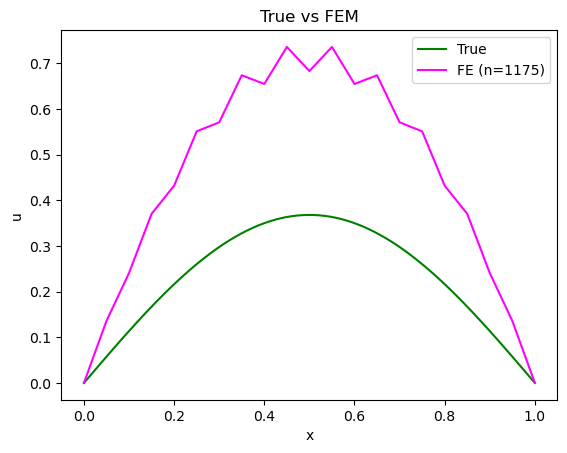

In [45]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 21
        # Timestep:
        n = 1175
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'FE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Forward Euler: decreasing N
Now, to check if the solution changes when the number of nodes decreases, I set **N = 5**, and tried playing around with different values of n, finding in this case (by trial-and-error), that the forward euler method becomes unstable for a timestep of 1/n, where **n <= 31**.

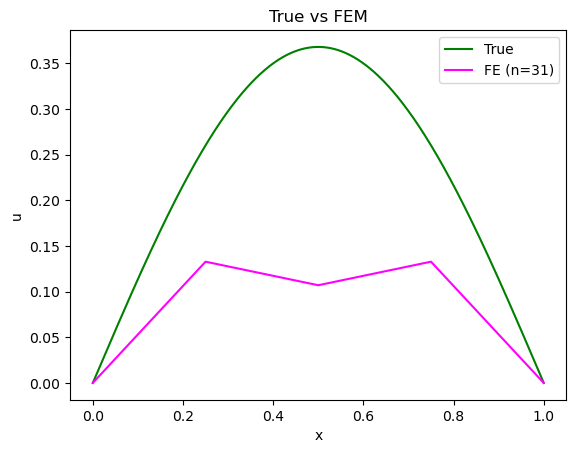

In [60]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 5
        # Timestep:
        n = 31
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'FE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Backward Euler: stable plot

Now, let's plot with backward euler method, nodes **N = 11**, and an arbitrary timestep of 1/n, where **n = 551**. As seen here, this method is fairly accurate, and close to the True function, _as long as the n value is sufficiently large_. 

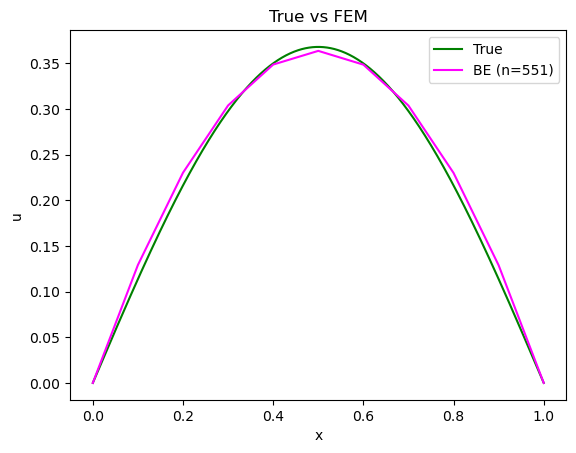

In [97]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 11
        # Timestep:
        n = 551
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        n = int(1/dt)
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'BE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Backward Euler: unconditional stability

The beauty of Backward Euler methods is that it is "unconditionally stable," in that even for very large timesteps, the method doesn't lose its stability. To illustrate this, let's plot with backward euler method, nodes **N = 11**, and an arbitrary timestep of 1/n, where **n = 6**. We see here that even when n is so much smaller, the estimation is stable. 

However, it's not at all accurate; we know that accuracy suffers as Δt (Δt = 1/n) increases, especially if it significantly exceeds spatial step-size h (h = 1/N). Backward Euler is first-order accurate in time (O(Δt)). When Δt is large relative to h, the solution becomes less accurate, which "smooths out" the solution, which results in excessive damping - thus, the solution evolving more slowly than the physical phenomenon.


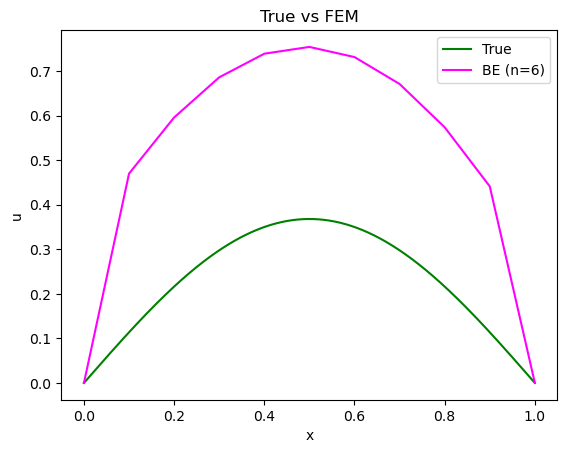

In [98]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 11
        # Timestep:
        n = 6
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        n = int(1/dt)
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'BE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Backward Euler: rule of thumb

As a general rule of thumb, when **Δt >= h^2**, we start to see accurate solutions. To illustrate this, I plot **n = 277**, which caused the Forward Euler method to crash, when we had 11 nodes. As seen in the graph below, our Backward Euler estimate is fairly close to the True function at this value, as **Δt >= h^2**.

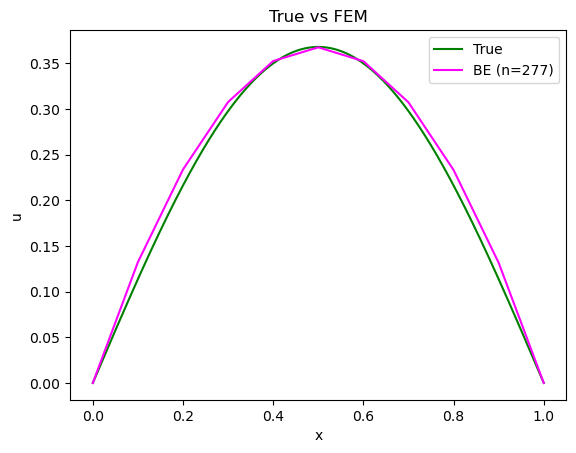

In [102]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 11
        # Timestep:
        n = 277
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        n = int(1/dt)
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'BE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Backward Euler: increasing N

To test out our Forward Euler runs with the Backward Euler method, I am going to use the same values as earlier, for an increased N value, where **N = 21** and subsequently **n = 1175**. Here, we see that even though **n >> N**, and subsequently **Δt >= h^2** we see our calculated function being inaccurate, and over-estimating the True value. This illustrates that the Backward Euler method, while unconditionally stable, only performs accurately under a certain range of **n** and **N**.

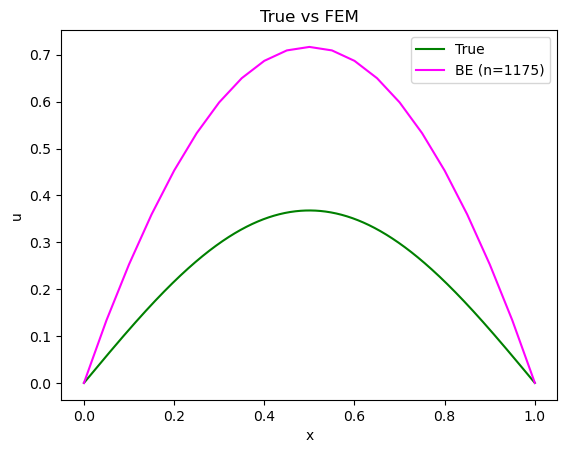

In [108]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 21
        # Timestep:
        n = 1175
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        n = int(1/dt)
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'BE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Backward Euler: decreasing N

Now, I am going to decrease the N value to **N = 5**, as we did earlier for Forward Euler, using **n = 31** (first unstable point under Forward Euler). 

Similar to our previous run, we see that even though **n >> N**, and subsequently **Δt >= h^2** we see our calculated function being inaccurate, and _under-estimating_ the True value. Again, this shows that the Backward Euler method only performs accurately under certain ranges of **n** and **N**, despite being stable everywhere.

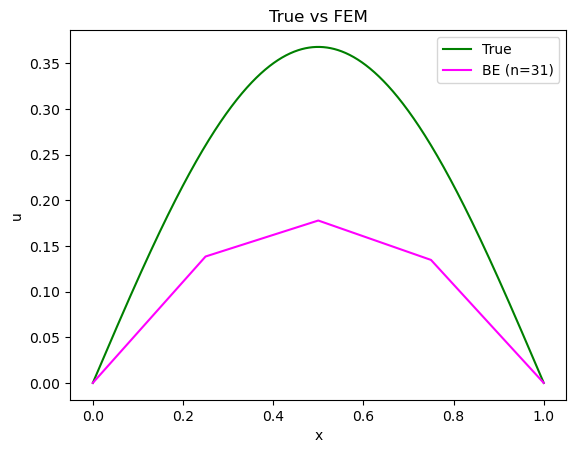

In [109]:
import numpy as np

def main():
    try:
        # Nodes:
        N = 5
        # Timestep:
        n = 31
        
        xi = np.linspace(0, 1, N)
        h = xi[1] - xi[0]
        dt = 1 / n
        n = int(1/dt)
        ts = np.linspace(0, 1, n + 1)
        
        # Method: Forward Euler (FE) or Backward Euler (BE)
        method = 'BE'
        fem_solve(N, n, xi, ts, h, dt, method)
        
    except ValueError as ve:
        print("Invalid input. Please enter numeric values.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()